### Задача оттока: варианты постановки, возможные способы решения
### 


1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,True,False
898,True,False
2398,True,False


Ананлогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [10]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [11]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [12]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Age'))])),
                                                ('Balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance'))])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts'))])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary'))]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [13]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [14]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


1. Recall показывает, что мы не находим 37% людей, которые уходят в отток
2. Precision показывает, что мы 35% людей посчитали оттоком, хотя они никуда не собираются

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:

Отрисуем матрицу ошибок

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


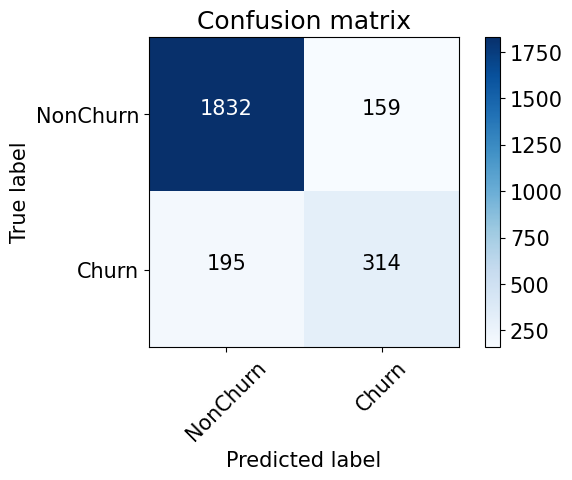

<Figure size 300x200 with 0 Axes>

In [17]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.figure(figsize=(3,2))
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

In [18]:
TP = cnf_matrix[1][1]
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]

expenses = (FP + TP) * 1 # наши вложения на удержание пользователей
income = TP * 2 # прибыль с каждого TP (true positive) - 2 доллара

income - expenses # результат

155

### Пример с перебором параметров с помощью GridSearch

Сетка с параметрами

In [19]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None],
        'classifier__class_weight': [{0:1, 1:4}, 'balanced_subsample']
        }

Запускаем перебор

In [20]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

Обучаем модель уже сновыми параметрами

In [21]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.3, 
                                          min_samples_leaf=1, class_weight = {0: 1, 1: 4},
                                          random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Age'))])),
                                                ('Balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance'))])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts'))])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary'))]))])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 4},
                                        max_features=0.3, random_state=42))])

Best Threshold=0.430000, F-Score=0.644, Precision=0.714, Recall=0.587
Confusion matrix, without normalization
[[1876  115]
 [ 216  293]]


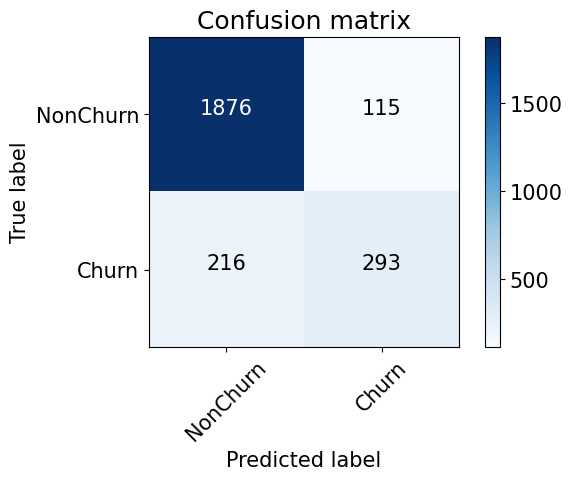

<Figure size 300x200 with 0 Axes>

In [22]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])

plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.figure(figsize=(3, 2))
plt.savefig("conf_matrix.png")
plt.show()

Метрики немного стали выше

#### Теперь проверим бизнесовую метрику

In [23]:
TP = cnf_matrix[1][1]
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]

expenses = (FP + TP) * 1 # наши вложения на удержание пользователей
income = TP * 2 # прибыль с каждого TP (true positive) - 2 доллара

income - expenses # результат

178

Удалось увеличить прибыль и теперь заработали 178 (евро)

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

In [41]:
cont_transformer = StandardScaler()

# Определение списка моделей для перебора
models = [
    ('random_forest', RandomForestClassifier(max_depth=None, max_features=0.3, 
                                          min_samples_leaf=1, class_weight = {0: 1, 1: 4},
                                          random_state=42)),
    ('gradient_boosting', GradientBoostingClassifier()),
    ('logistic_regression', LogisticRegression()),
    ('xgboost', XGBClassifier())
]

# Определение параметров для перебора моделей
params = {
    'classifier': [model for _, model in models]
}

# Создание пайплайна с перебором моделей
pipeline = Pipeline([
    ('features', feats),
    ('cont_transformer', cont_transformer),
    ('classifier', RandomForestClassifier())  # Placeholder, will be updated later
])

# Создание объекта GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=params, cv=6, refit=False)

# Обучение и выбор лучшей модели
grid_search.fit(X_train, y_train)

# Вывод лучшей модели
best_model = grid_search.best_params_['classifier']
print("Best Model:", best_model)

# Обновление пайплайна с лучшей моделью
pipeline.set_params(classifier=best_model)

# Обучение с лучшей моделью
pipeline.fit(X_train, y_train)


Best Model: GradientBoostingClassifier()


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Age'))])),
                                                ('Balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance'))])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts'))])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary'))]))])),
                ('cont_transformer', StandardScaler()),
                ('classifier', GradientBoostingClassifier())])

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597
Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


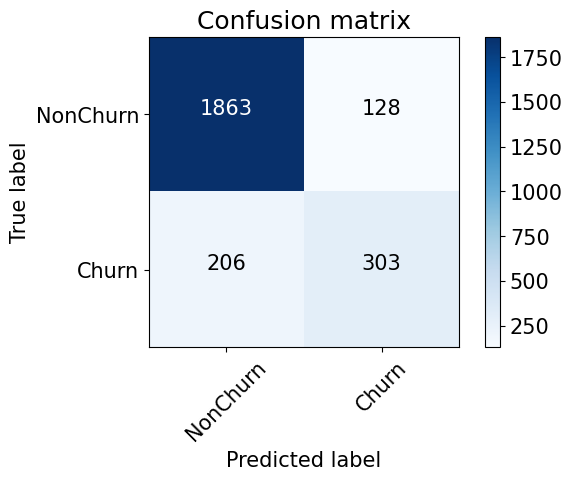

<Figure size 300x200 with 0 Axes>

In [31]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# Находим индекс наибольшего значения F-меры
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])

plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.figure(figsize=(3, 2))
plt.savefig("conf_matrix.png")
plt.show()

In [32]:
TP = cnf_matrix[1][1]
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]

expenses = (FP + TP) * 1 # наши вложения на удержание пользователей
income = TP * 2 # прибыль с каждого TP (true positive) - 2 доллара

income - expenses # результат

175

In [38]:
# Создаем пайплан (GradientBoostingClassifier)
pipeline = Pipeline([
    ('features', feats),
    ('cont_transformer', cont_transformer),
    ('classifier', GradientBoostingClassifier(learning_rate=0.1))
])

# Настройка параметров для лучшей модели (GradientBoostingClassifier)
gb_params = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__subsample': [0.8, 0.9, 1.0], # Меньше 1.0 позволяет случайно выбирать подмножество образцов на каждой итерации обучения.
    'classifier__min_samples_leaf': [1, 3, 5] # Более высокое значение может помочь справиться с переобучением, ограничивая рост деревьев.
}

# Создание объекта GridSearchCV для выбора лучшей модели
gb_grid_search = GridSearchCV(pipeline, param_grid=gb_params, cv=6, refit=False)

# Подгонка и выбор лучших параметров для лучшей модели
gb_grid_search.fit(X_train, y_train)

# Вывод лучших параметров для лучшей модели
best_params = gb_grid_search.best_params_
print("Best Parameters for Best Model:", best_params)

# Обновление конвейера с лучшими параметрами для лучшей модели
pipeline.set_params(**best_params)

# Обучение лучшей модели с лучшими параметрами
pipeline.fit(X_train, y_train)


Best Parameters for Best Model: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                                  NumberSelector(key='Age'))])),
                                                ('Balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance'))])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts'))])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary'))]))])),
                ('cont_transformer', StandardScaler()),
                ('classifier', GradientBoostingClassifier(n_estimators=200))])

#### Best Parameters for Best Model (GradientBoostingClassifier): 
- 'classifier__learning_rate': 0.1, 
- 'classifier__max_depth': 3, 
- 'classifier__min_samples_leaf': 1, 
- 'classifier__n_estimators': 200, 
- 'classifier__subsample': 1.0

Best Threshold=0.387128, F-Score=0.651, Precision=0.682, Recall=0.623
Confusion matrix, without normalization
[[1843  148]
 [ 193  316]]


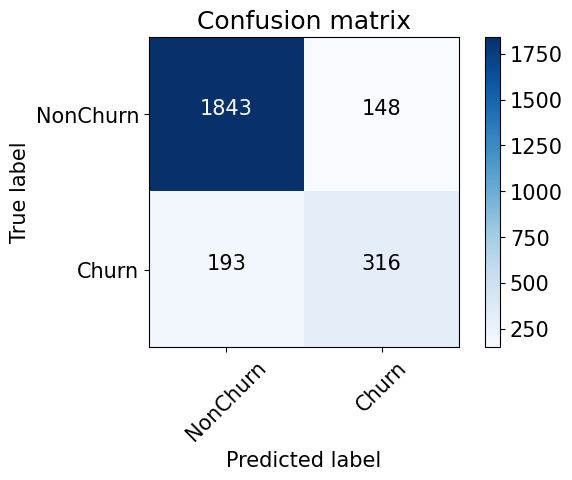

<Figure size 300x200 with 0 Axes>

In [39]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# Находим индекс наибольшего значения F-меры
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])

plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.figure(figsize=(3, 2))
plt.savefig("conf_matrix.png")
plt.show()

In [40]:
TP = cnf_matrix[1][1]
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]

expenses = (FP + TP) * 1 # наши вложения на удержание пользователей
income = TP * 2 # прибыль с каждого TP (true positive) - 2 доллара

income - expenses # результат

168

#### Вывод:
- RandomForestClassifier лучше справляется с определением позитивных случаев (TP), что приводит к большей прибыли и меньшим затратам на удержание пользователей. 
- Не смотря на то, что наилучшая модель с точки зрения метрик DS GradientBoostingClassifier лучше всех предсказала количесто действительно ушедших в отток клиентов 316, с точки зрения бизнес метрики, проигрывает RandomForestClassifier.
- В конкретных бизнес-сценариях и контексте могут быть другие метрики, которые также важны. Например, можно учитывать стоимость привлечения новых клиентов и стоимость удержания существующих клиентов при принятии решений.
- Однако, в целом, F1-мера является широко применяемой метрикой и может служить хорошей отправной точкой для оценки моделей в задачах оттока клиентов.